[Canvas Link](https://smu.instructure.com/courses/119111/assignments/945173) \
[Data Source](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset?resource=download)
##### Authors
- 1

In [1]:
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
import umap.plot
from matplotlib.lines import Line2D
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler

warnings.filterwarnings("ignore")

df = pd.read_csv("data\healthcare-dataset-stroke-data.csv")

# preprocess
print(df.shape)
df = df.dropna()
print(df.shape)
labels = df['stroke']
data = df.drop(['id', 'stroke'], axis=1)

d:\Program\Miniconda\envs\tf\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


(5110, 12)
(4909, 12)


In [2]:
# encoded categorical data
data_encoded = pd.get_dummies(data, columns=["gender","ever_married", "work_type", "Residence_type", "smoking_status"])

# scale
data_scaled = StandardScaler().fit_transform(data_encoded)

#### 3.2 Questions relavant to the dataset
##### 3.2.1 How many principal componets can roughtly represent the features?

((4909, 21),
 (4909, 15),
 array([0.19319848, 0.09927776, 0.09565541, 0.08121564, 0.06755983,
        0.05915422, 0.05516797, 0.05224368, 0.05035796, 0.04726518,
        0.0452509 , 0.0435231 , 0.03867324, 0.03510466, 0.02423411]),
 0.9878821163521972)

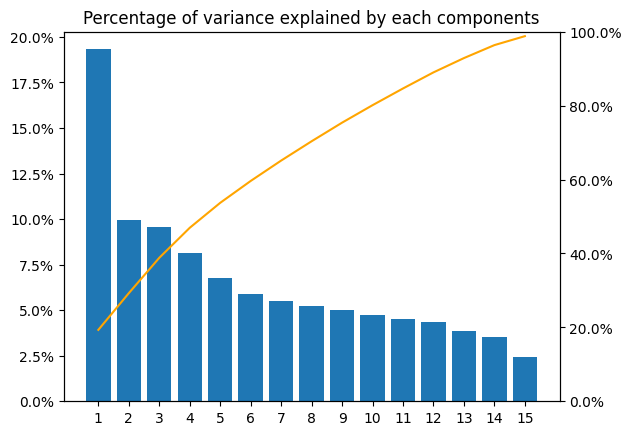

In [3]:
n_components = 15
pca = PCA(n_components)
data_pca = pca.fit_transform(data_scaled)

accumulated_ratio = [pca.explained_variance_ratio_[0]]
for r in pca.explained_variance_ratio_[1:]:
    accumulated_ratio.append(accumulated_ratio[-1] + r)

# ploting
plt.bar(range(1, n_components+1), pca.explained_variance_ratio_)
plt.xticks(range(1, n_components+1))
plt.yticks(np.arange(0, 0.21, 0.025), [f"{x*100:.1f}%" for x in np.arange(0, 0.21, 0.025)])

ax = plt.twinx()
ax.set_yticks(np.arange(0, 1.01, 0.2), [f"{x*100:.1f}%" for x in np.arange(0, 1.01, 0.2)])
ax.set_ylim(0,1)
ax.plot(range(1, n_components+1), accumulated_ratio, color='orange')

plt.title("Percentage of variance explained by each components")
data_scaled.shape, data_pca.shape, pca.explained_variance_ratio_, sum(pca.explained_variance_ratio_)

According to the figure above, first 13 components explained over 90% of variance. Meanwhile, the first component takes up the most of variance, appoximately 20%.

##### 3.2.2. Is the data inherently separable after applying demension deduction?

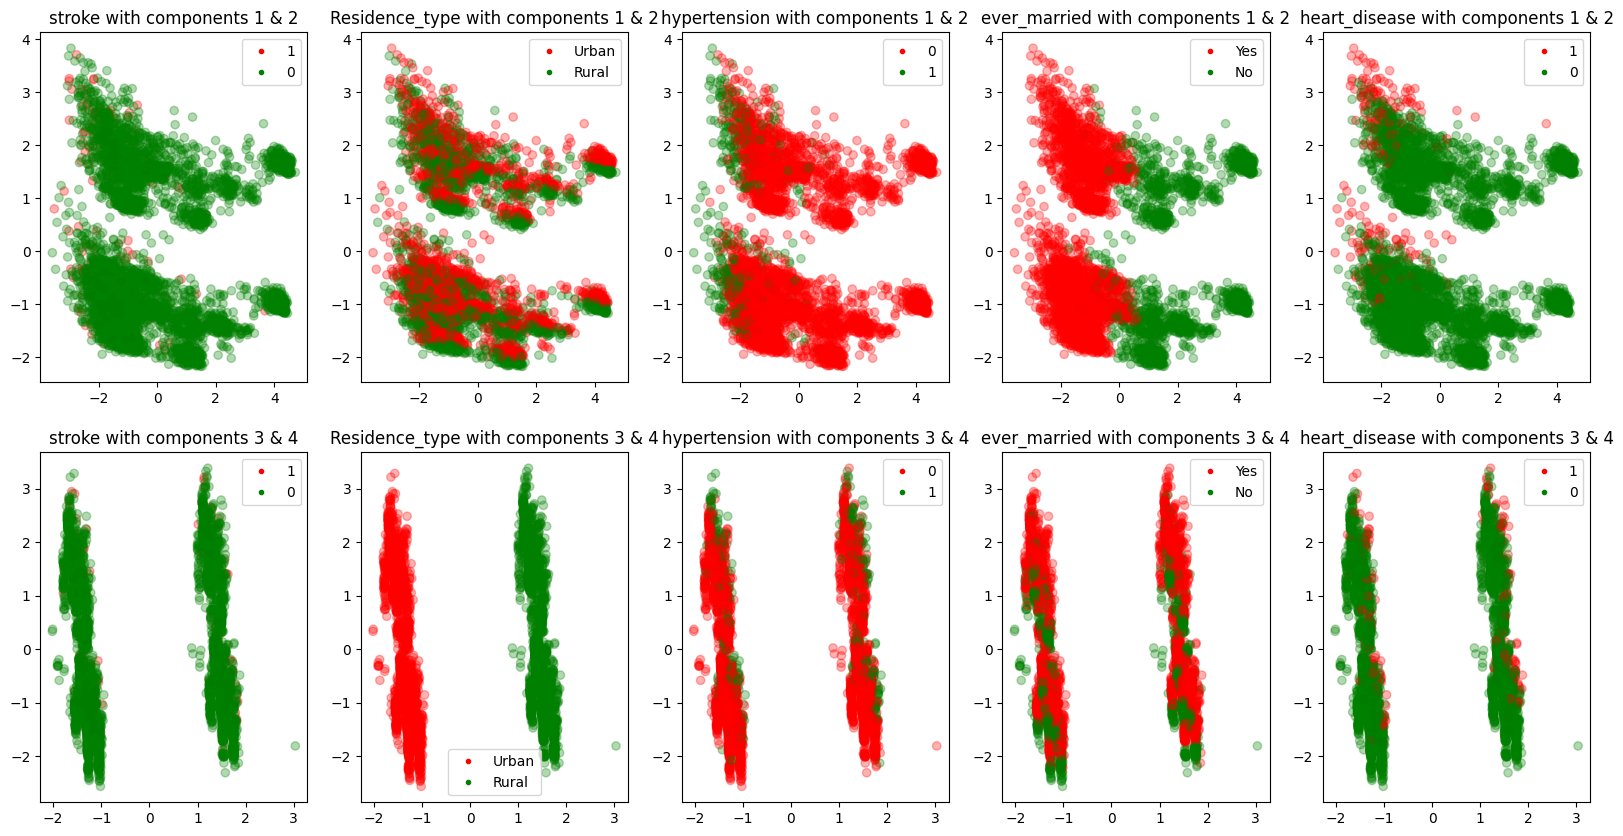

In [4]:
custom_handles = [Line2D([], [], marker='.', color='red', linestyle='None'),
                  Line2D([], [], marker='.', color='green', linestyle='None')]

fig = plt.figure(figsize=(20, 10))
cols = ['stroke','Residence_type', 'hypertension', 'ever_married', 'heart_disease']
index = 0
for i_components in[(0,1), (2,3)]:
    for col in cols:
        index += 1
        
        if col == 'stroke':
            unique_types = list(labels.unique())
            plot_colors = labels.map(lambda x: 'red' if x == unique_types[0] else 'green')
        else:
            unique_types = list(data[col].unique())
            plot_colors = data[col].map(lambda x: 'red' if x == unique_types[0] else 'green')
        ax1 = fig.add_subplot(2, len(cols), index)
        ax1.scatter(
            data_pca[:, i_components[0]],
            data_pca[:, i_components[1]],
            c=plot_colors, alpha=0.3)


        ax1.legend(handles = custom_handles, labels= unique_types)
        plt.title(f"{col} with components {i_components[0]+1} & {i_components[1]+1}", fontsize = 12)


As the figures shown above, the data is separable on some fields. Using the 3rd and 4th principal components, the data is clearly separated in terms of urban or rural residence. With the first and second component, the data can be seprated with hypertension and ever_married status. In other cases, the data points are entangled together. There is no clearly boundary between two classes.

##### 3.2.3 How the classification results diffs with and without PCA?

Text(0.5, 1.0, 'Train and Test Time')

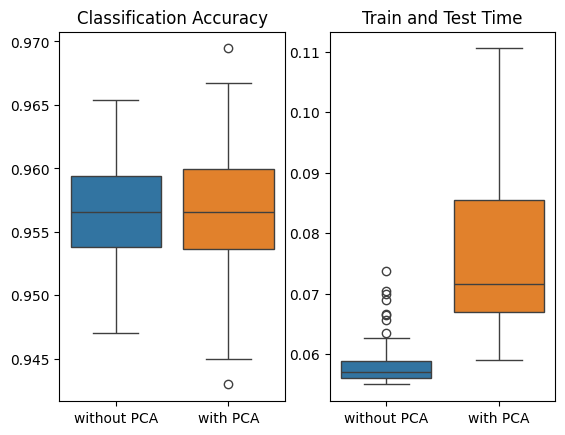

In [16]:
acc_without_pcas, acc_pcas = [], []
time_without_pcas, time_pcas = [], []
for _ in range(100):
    # prepare the data without PCA
    X_train, X_test, y_train, y_test = train_test_split(data_scaled, labels, train_size=0.7)
    
    knn = KNeighborsClassifier()
    s_t = time.time()
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    time_without_pcas.append(time.time() - s_t)
    cm = confusion_matrix(y_test, y_pred)
    acc_without_pcas.append(np.sum(np.diag(cm))/ np.sum(cm))

    # prepare the data with PCA
    X_train, X_test, y_train, y_test = train_test_split(data_pca, labels, train_size=0.7)

    knn = KNeighborsClassifier()
    s_t = time.time()
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    time_pcas.append(time.time() - s_t)
    cm = confusion_matrix(y_test, y_pred)
    acc_pcas.append(np.sum(np.diag(cm))/ np.sum(cm))

ax = plt.subplot(121)
sns.boxplot(data = [acc_without_pcas, acc_pcas])
plt.xticks([0,1], ['without PCA','with PCA'])
plt.title("Classification Accuracy")
ax = plt.subplot(122)
sns.boxplot([time_without_pcas, time_pcas])
plt.xticks([0,1], ['without PCA','with PCA'])
plt.title("Train and Test Time")

As the illustration shown above, the average classification accuracies are basically same. However, classification without PCA leads to a more stable result. Due to the small size of the dataset, the training and testing time is counterintuitive. On this dataset, more time is spent on data after applying PCA.

### 4. Exceptional Work
#### 4.1 Overall Quality

#### 4.2 Additional analysis

UMAP is one of dimension deduction methods. Compare to other techniques such as t-SNE, UMAP offers a number of advantages. Firstly, it's fast. On MINST dataset, UMAP can project the data less than 3 minutes, while t-SNE can take up to 45 minutes. Secondly, UMAP better preserve global structure of the data. This due to UMAP's strong theoretical foundations. Lastly, UMAP offers more understandable parameters that make it a more effective tool for visualizing high dimensional data.

UMAP starts by constructing a graph that captures relationships between data points. It then optimizes a low-dimensional representation that preserves these relationships, ensuring that nearby points in the high-dimensional space remain close in the reduced space. UMAP strikes a balance between preserving local structure, representing fine details, and maintaining global structure, capturing broader patterns.

(5110, 12)
(4909, 12)


Text(0.5, 0.92, 'Supervised UMAP Projection of the Stroke Data')

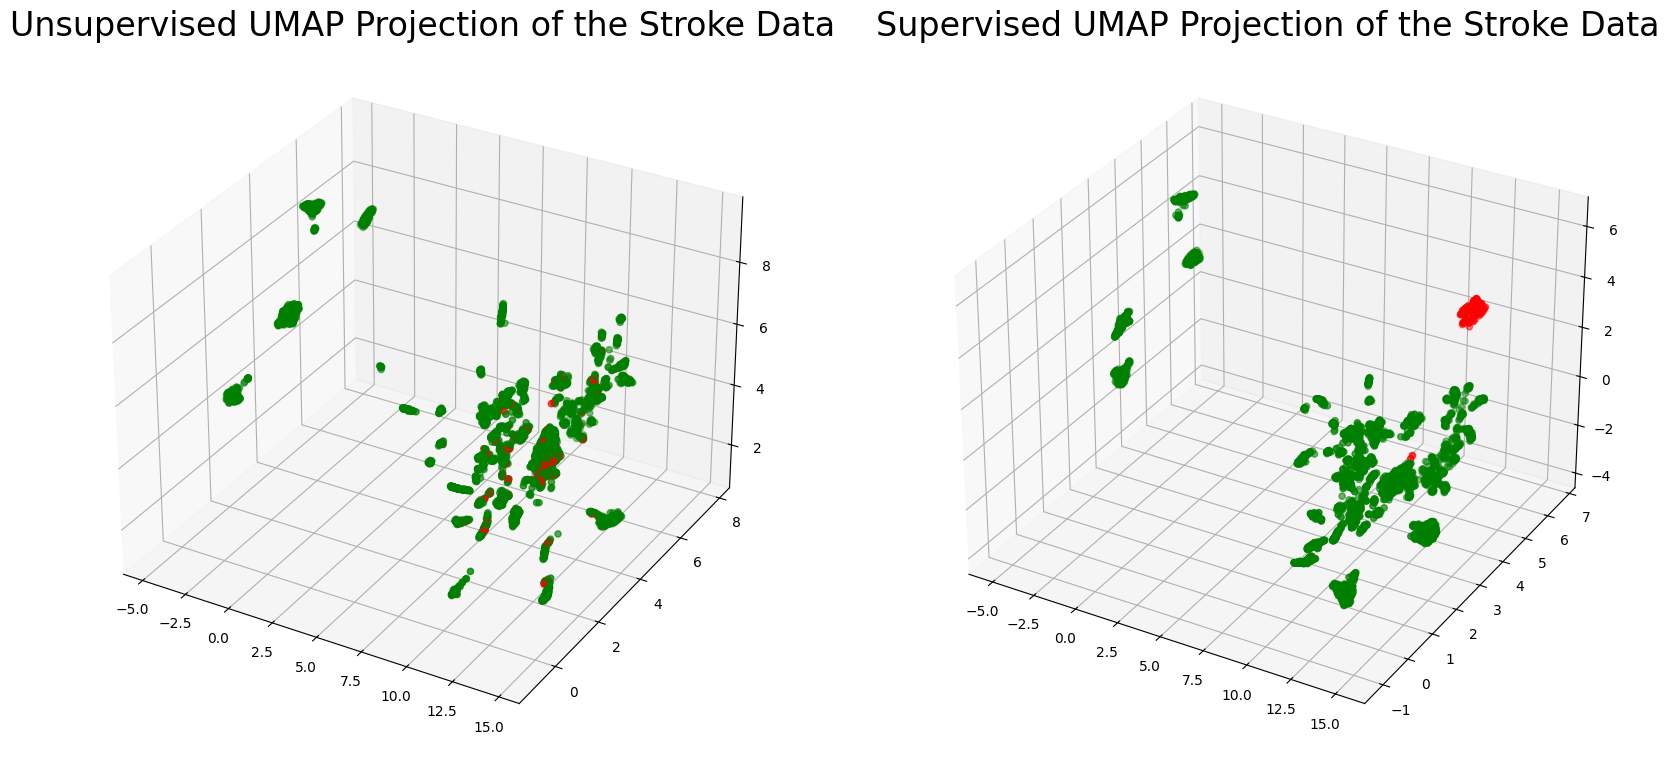

In [16]:
# UMAP dimension deduction
data_umap_unsupervised = umap.UMAP(n_components=3, n_neighbors=500).fit_transform(data_scaled)
data_umap_supervised = umap.UMAP(n_components=3, n_neighbors=500).fit_transform(data_scaled,  y = labels)

# plot the results
plot_colors = labels.map(lambda x: 'red' if x == 1 else 'green')

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(
    data_umap_unsupervised[:, 0],
    data_umap_unsupervised[:, 1],
    data_umap_unsupervised[:, 2],
    c=plot_colors)
plt.title('Unsupervised UMAP Projection of the Stroke Data', fontsize=24)

ax = fig.add_subplot(122, projection='3d')
ax.scatter(
    data_umap_supervised[:, 0],
    data_umap_supervised[:, 1],
    data_umap_supervised[:, 2],
    c=plot_colors)
plt.title('Supervised UMAP Projection of the Stroke Data', fontsize=24)

From the plots shown, the unsupervised UMAP failed to separate the dataset. In contrast, the supervised UMAP is able to separate the data into distinct clusters with data labels, despite that a small portion of stroke data is mixed with other data points.